## Instruções para execução

Você deve baixar os arquivos 'Equalização e Binarização.ipynb', 'img.tiff' e 'folha.png' em seu computador e executar. As imagens devem estar no mesmo diretório que esse arquivo, ou o caminho dessas imagens deve ser modificado explicitamente no código.

## Implementando Equalização

### Importando Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import base64
import math

### Importando imagem

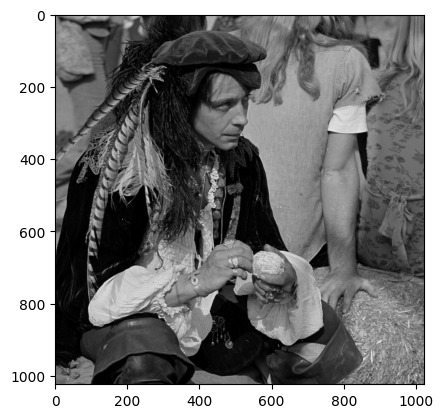

In [2]:
img = Image.open('img.tiff')  # armazena a imagem na variável

plt.imshow(img, cmap='gray')  # plota a imagem

### Criando Histograma

In [3]:
def instanciando_histograma():
    vetor_hist = []
    
    for i in range(0, 256):
        vetor_hist.append(str(i))
        vetor_hist.append(0)
    
    dici_hist = {vetor_hist[i]: vetor_hist[i+1] for i in range(0, len(vetor_hist), 2)}
    
    return dici_hist

histograma = instanciando_histograma()

In [4]:
def contar_valores_intensidade(hist, imagem):
    for linha in range(0, imagem.height):  # itera as linhas da imagem
        for coluna in range(0, imagem.width):  # itera as colunas da imagem
            var = imagem.getpixel((linha, coluna))  # pixel por pixel
            hist[str(var)] = hist[str(var)] + 1
            
    return hist

histograma = contar_valores_intensidade(histograma, img)

### Plotando Histograma

#### Eixo Y: quantas vezes o valor apareceu na imagem
#### Eixo X: níveis de intensidade

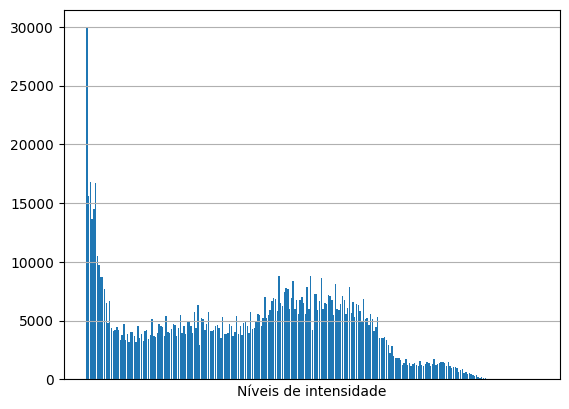

In [5]:
def plot_hist(hist, hist2=''):
    if hist2 != '':
        figure, axarr = plt.subplots(1,2, figsize=(25, 10))
        axarr[0].bar(hist.keys(), hist.values())
        axarr[1].bar(hist2.keys(), hist2.values())
    else:
        plt.bar(hist.keys(), hist.values())
        plt.xlabel("Níveis de intensidade")
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        plt.grid(True)
        plt.show()
    
plot_hist(histograma)

### Calculando probabilidades do histograma

In [6]:
def get_prob_hist(hist, pixels):  # função para calcular a probabilidade do valor aparecer
    hist_prob = {}
    
    for i in range(0, 256):
        hist_prob[str(i)] = hist[str(i)] / pixels
    
    return hist_prob

num_pixels = img.height * img.width
hist_prob = get_prob_hist(histograma, num_pixels)

In [7]:
def get_prob_acumulada(hist_prob):
    acc_prob = {}
    soma_prob = 0
    
    for i in range(0, 256):
        if i == 0:
            pass
        else:
            soma_prob += hist_prob[str(i-1)]
        
        acc_prob[str(i)] = hist_prob[str(i)] + soma_prob
        
    return acc_prob

prob_acumulada = get_prob_acumulada(hist_prob)

### Calculando novos valores

In [8]:
def get_novos_valores(prob_acumulada):
    novos_valores = {}
    
    for i in range(0, 256):
        novos_valores[str(i)] = np.ceil(prob_acumulada[str(i)] * 255)
        
    return novos_valores

novos_valores = get_novos_valores(prob_acumulada)

### Equalizando imagem

In [9]:
def equalizar_hist(imagem, novos_valores):
    for linha in range(0, imagem.height):
        for coluna in range(0, imagem.width):
            imagem.putpixel((linha, coluna), int(novos_valores[str(int(imagem.getpixel((linha, coluna))))]))
            
    return imagem

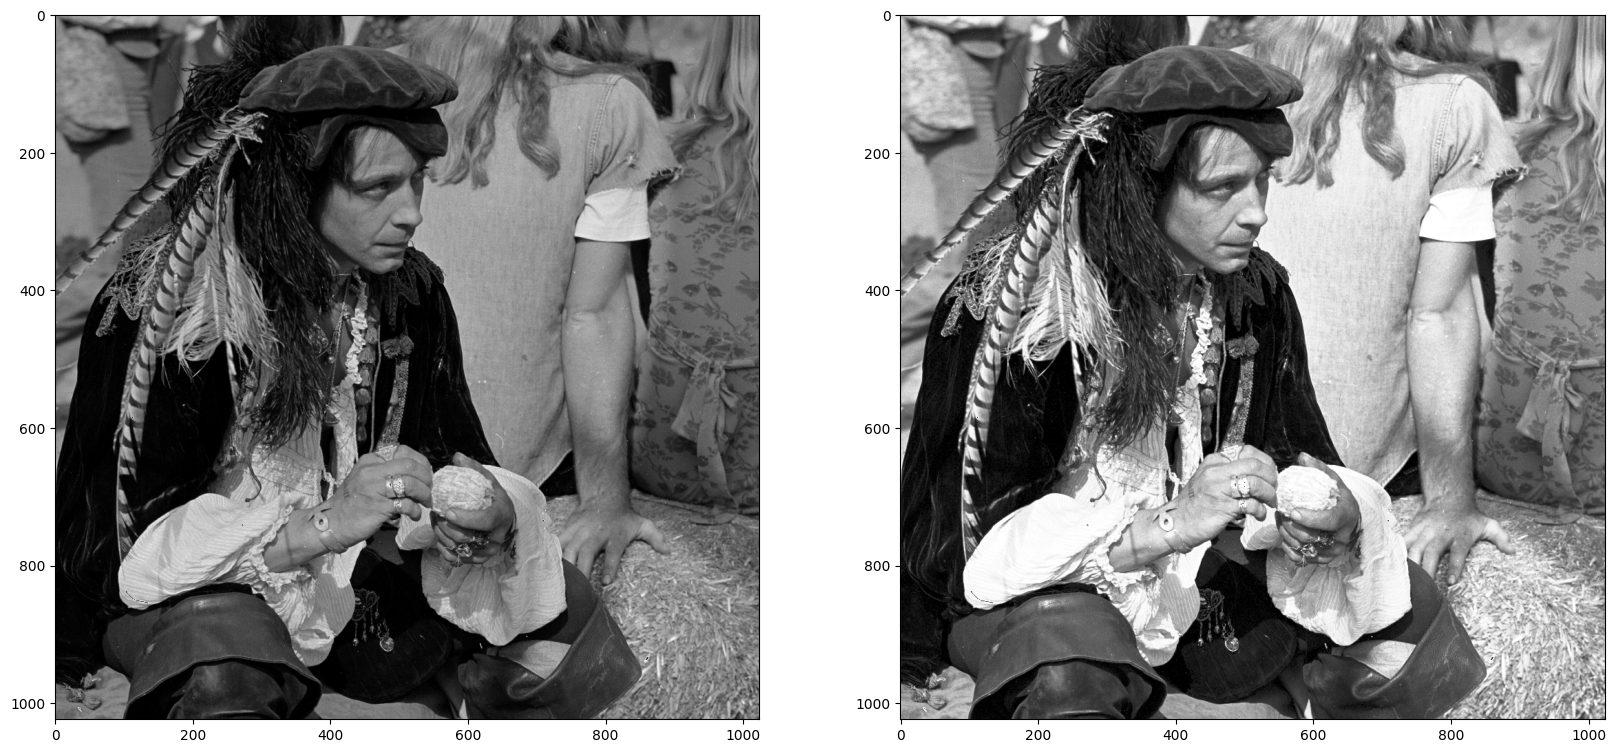

In [10]:
imagem_equalizada = equalizar_hist(img.copy(), novos_valores)
figure, axarr = plt.subplots(1,2, figsize=(20, 10))
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(imagem_equalizada, cmap='gray')

#### <center> Imagem original e imagem equalizada, respectivamente

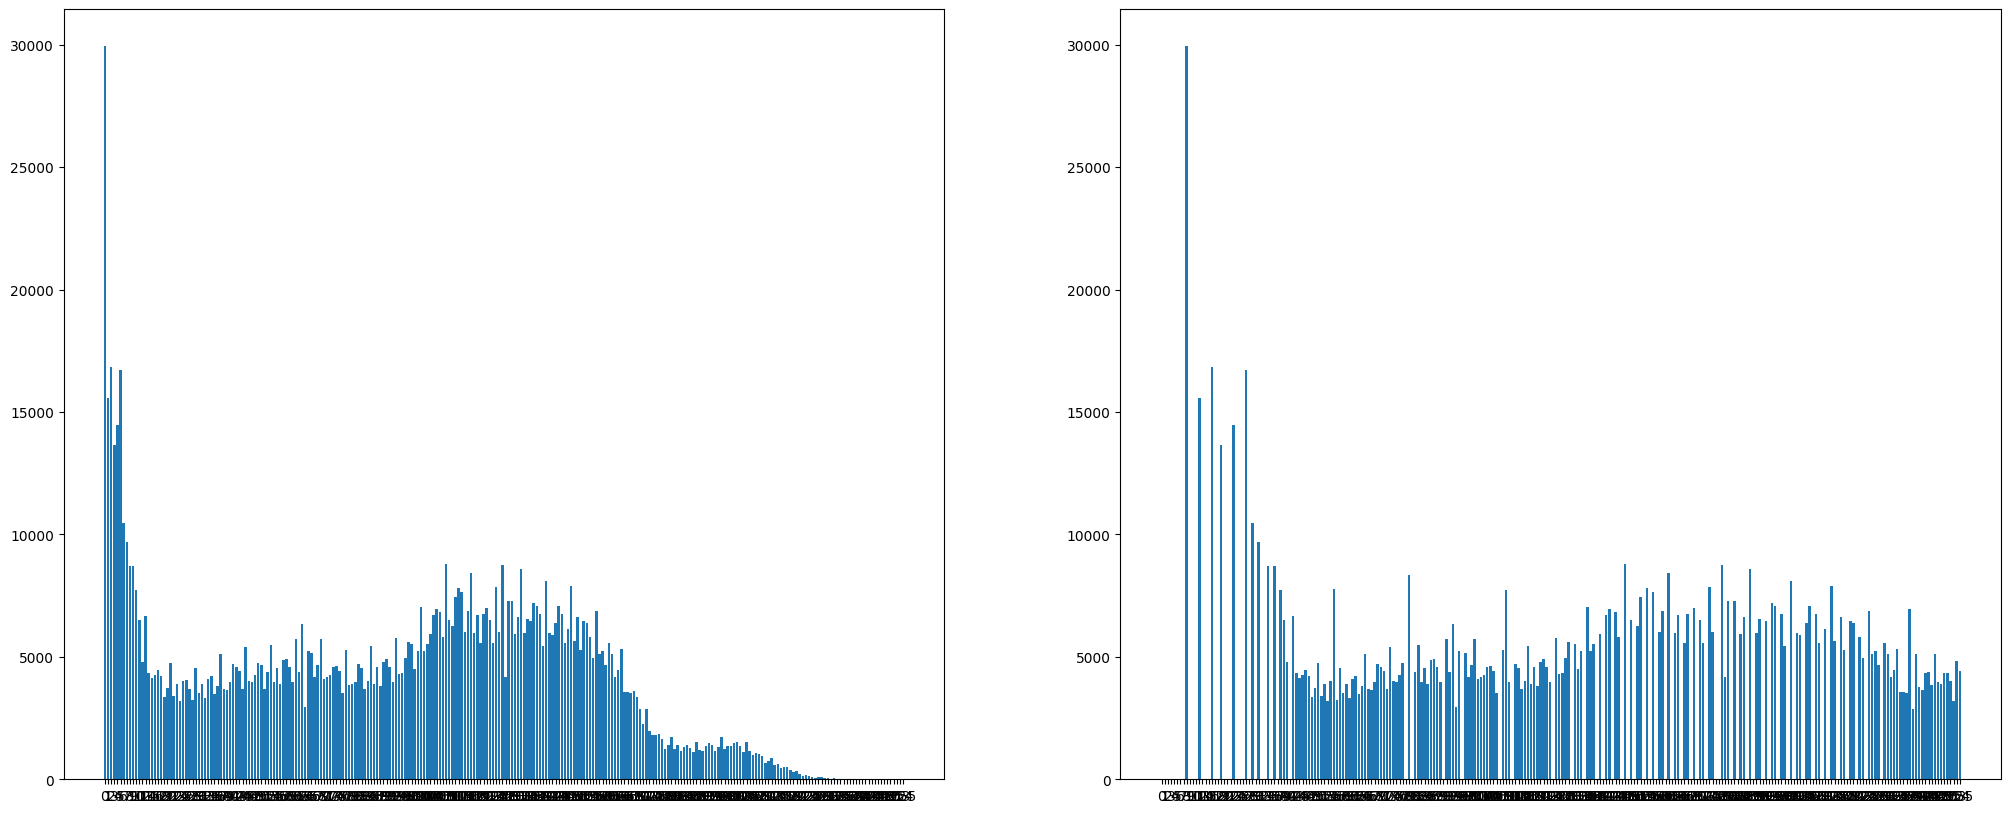

In [11]:
histograma_eq = instanciando_histograma()
histograma_eq = contar_valores_intensidade(histograma_eq, imagem_equalizada)
plot_hist(histograma, histograma_eq)

#### <center> Histograma da imagem original e da imagem equalizada, respectivamente

## Implementando Binarização

### Importando imagem

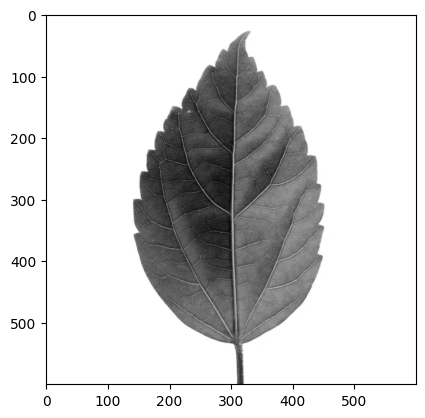

In [12]:
imagem = Image.open('folha.png').convert('L')  # armazena a imagem já convertida para escalas de cinza na variável

plt.imshow(imagem, cmap='gray')  # plota a imagem

imagem = np.asarray(imagem)  # transforma a imagem em um NumPy array

### Calculando critérios de Otsu

In [13]:
def computa_criterio_otsu(im, th):
    # cria a imagem limitada
    img_limitada = np.zeros(im.shape)
    img_limitada[im >= th] = 1

    # computa os pesos
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(img_limitada)
    peso1 = nb_pixels1 / nb_pixels
    peso0 = 1 - peso1

    # se uma das classes estiver vazia, o limite não será considerado na busca pelo melhor limite
    if peso1 == 0 or peso0 == 0:
        return np.inf

    # encontra todos os pixels pertencentes a cada classe
    val_pixels1 = im[img_limitada == 1]
    val_pixels0 = im[img_limitada == 0]

    # computa a variância dessas classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return peso0 * var0 + peso1 * var1

### Calculando o limite de Otsu

In [14]:
def limite_otsu(img: np.ndarray) -> np.ndarray:
    limite_range = range(np.max(img)+1)
    criterio = np.array([computa_criterio_otsu(img, th) for th in limite_range])

    # o melhor limite é aquele que minimiza o critério de Otsu
    melhor_limite = limite_range[np.argmin(criterio)]

    binario = img
    binario[binario > melhor_limite] = 255
    binario[binario <= melhor_limite] = 0

    return binario

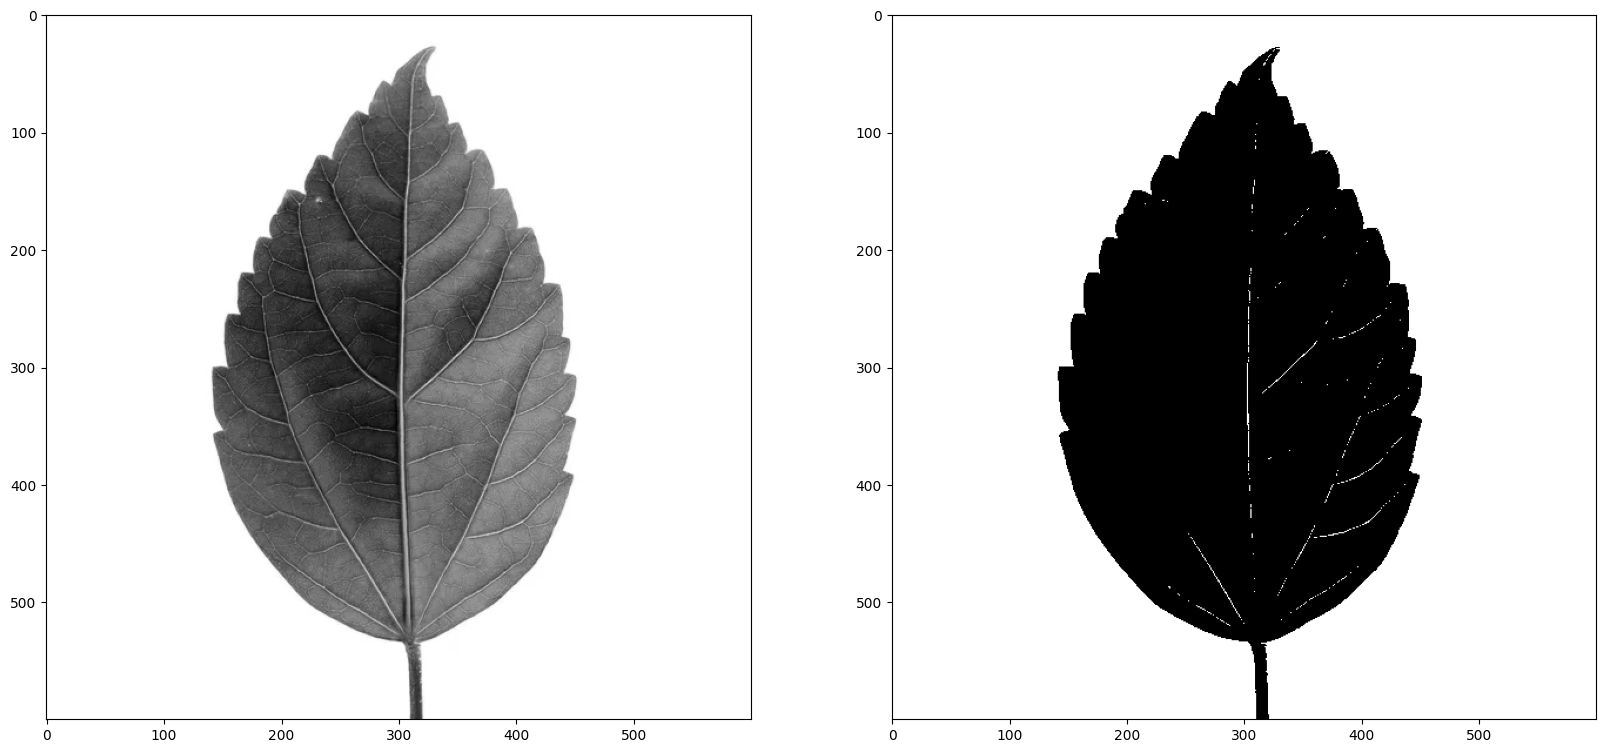

In [15]:
imagem_binarizada = limite_otsu(imagem.copy())
figure, axarr = plt.subplots(1,2, figsize=(20, 10))
axarr[0].imshow(imagem, cmap='gray')
axarr[1].imshow(imagem_binarizada, cmap='gray')

#### <center> Imagem original e imagem binarizada, respectivamente